In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd 
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import seaborn as sns
import shapely.speedups
shapely.speedups.enable()

Download the following data and save extract it into the ./data folder of this project:

- http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip

- https://maps.amsterdam.nl/open_geodata/geojson.php?KAARTLAAG=GEBIED_STADSDELEN&THEMA=gebiedsindeling

Load the POI data:

In [2]:
points = gpd.read_file("./data/gis_osm_pois_free_1.shp")

filter the data for restaurants (or any other POI category)

In [3]:
points = points[points["fclass"] == "restaurant"]

take a quick look into the data

In [4]:
points

osm_id  code      fclass                name  \
92       30839687  2301  restaurant          de Eethoek   
144      34043796  2301  restaurant        Sizzling Wok   
146      34044093  2301  restaurant      De Roode Leeuw   
309      94829656  2301  restaurant          Pata Negra   
314      95288389  2301  restaurant               Meram   
...           ...   ...         ...                 ...   
36941  7124541137  2301  restaurant              Bregje   
37028  7125482608  2301  restaurant              Bregje   
37099  7126562153  2301  restaurant        Antiek China   
37100  7126562155  2301  restaurant            Duinberk   
37111  7137254485  2301  restaurant  Vleesch noch Visch   

                       geometry  
92     POINT (4.68719 52.60357)  
144    POINT (4.94756 52.29292)  
146    POINT (4.89360 52.37375)  
309    POINT (4.92517 52.36060)  
314    POINT (4.92556 52.35599)  
...                         ...  
36941  POINT (4.54346 52.40140)  
37028  POINT (5.16396 52.27562)  
37099  POINT (4.69355 52.70252)  
37100  POINT (4.69367 52.70238)  
37111  POINT (4.87139 52.37963)  

[2797 rows x 5 columns]

load the shapefile for the city of amsterdam

In [5]:
city = gpd.read_file("./data/geojson.json")

take a quick look into this data as well

In [6]:
city

Stadsdeel_code   Stadsdeel    Opp_m2  \
0              A     Centrum   8043500   
1              B   Westpoort  28991600   
2              E        West  10629900   
3              F  Nieuw-West  38015500   
4              K        Zuid  17274000   
5              M        Oost  30594900   
6              N       Noord  63828800   
7              T    Zuidoost  22113700   

                                            geometry  
0  POLYGON ((4.93298 52.37039, 4.93295 52.37053, ...  
1  POLYGON ((4.88587 52.39936, 4.88271 52.40169, ...  
2  POLYGON ((4.89509 52.38868, 4.89468 52.38993, ...  
3  POLYGON ((4.85050 52.36423, 4.85046 52.36518, ...  
4  POLYGON ((4.91499 52.34213, 4.91495 52.34242, ...  
5  POLYGON ((5.03906 52.35456, 5.03882 52.35809, ...  
6  POLYGON ((5.07917 52.38864, 5.07427 52.41383, ...  
7  POLYGON ((5.02155 52.30244, 5.02147 52.30312, ...

perform a spatial join between the points and polygons and filter out any points that did not match with the polygons

In [7]:
points = gpd.sjoin(points, city, how="left")
points = points.dropna(subset=["index_right"])

plot both data sets to see if the spatial join was performed correctly

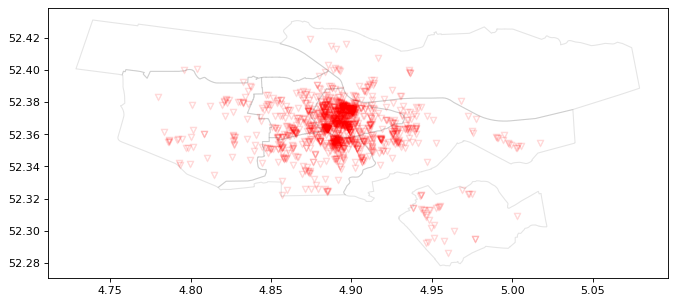

In [8]:
# edit the figure size however you need to
plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
# create plot and axes
fig = plt.plot()
ax1 = plt.axes()
# these values can be changed as needed, the markers are LaTeX symbols
city.plot(ax=ax1, alpha=0.1, edgecolor="black", facecolor="white")
points.plot(ax=ax1, alpha = 0.1, color="red", marker='$\\bigtriangledown$',)
ax1.figure.savefig('./data/plot1.png')

to get a nice background map, we need to find out all the boundaries of our data and save that for later plotting

In [9]:
bounding_box = [points["geometry"].x.min(), points["geometry"].x.max(), points["geometry"].y.min(), points["geometry"].y.max()]

In [10]:
bounding_box

[4.7799629, 5.0172533, 52.2864691, 52.4193587]

Use these bounding box values and put them into the area fields on this website: https://www.openstreetmap.org/export#map=12/52.3530/4.8556 the area should look like this:

![screenshot](resources/img.png)

You can save the image by clicking on the share button on the right and save it as a PNG-file with the name `map.png`.

load the background map

In [11]:
osm_map = plt.imread("./data/map.png")

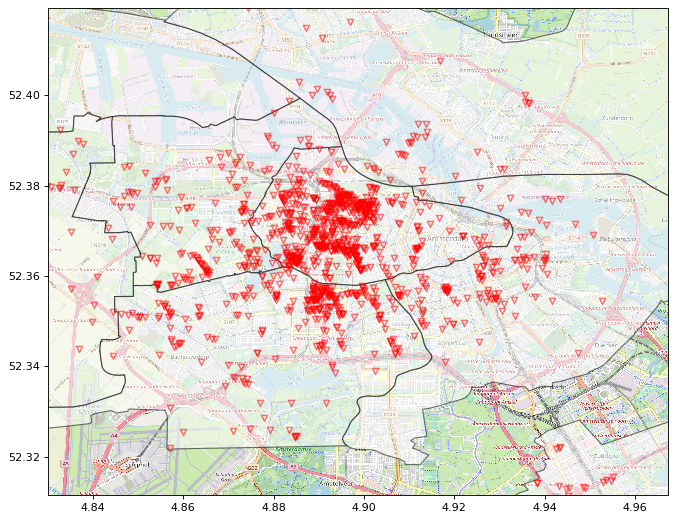

In [12]:
plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')

fig = plt.plot()
ax1 = plt.axes()
# to see more of the data, we use the bounding box and zoom in a little by adding and subtracting values of our borders
ax1.set_xlim(bounding_box[0]+0.05, bounding_box[1]-0.05)
ax1.set_ylim(bounding_box[2]+0.025, bounding_box[3])
city.plot(ax=ax1, alpha=0.55, edgecolor="black", facecolor="white")
points.plot(ax=ax1, alpha = 0.4, color="red", marker='$\\bigtriangledown$',)
# add the osm_map as a background to the extend of the bounding box
ax1.imshow(osm_map, zorder=0, extent = bounding_box)
ax1.figure.savefig('./data/plot2.png')

To get an impression on the spatial distribution, a KDE plot might help. For this we use the `kdeplot`-function from seaborn.

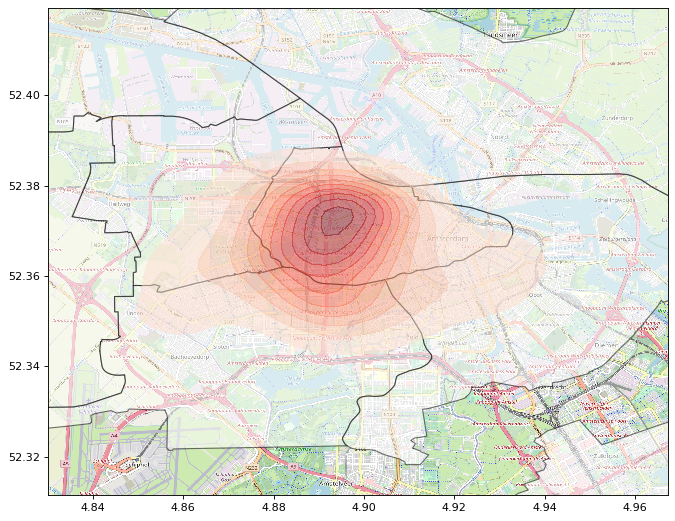

In [13]:
plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.plot()
ax1 = plt.axes()
ax1.set_xlim(bounding_box[0]+0.05, bounding_box[1]-0.05)
ax1.set_ylim(bounding_box[2]+0.025, bounding_box[3])
city.plot(ax=ax1, alpha=0.55, edgecolor="black", facecolor="white")
sns.kdeplot(points["geometry"].x, points["geometry"].y, shade=True, alpha=0.5, cmap="Reds", shade_lowest=False)
ax1.imshow(osm_map, zorder=0, extent = bounding_box)
ax1.figure.savefig('./data/plot3.png')

instead of drawing the KDE as a single shape, we can also color our points according to the density. For this we calculate the gaussian KDE separately and use the result as z-values for our plot. The markers can be changed to ones liking, for this case I settled with simple points.

In [ ]:
xy = np.vstack([points["geometry"].x,points["geometry"].y])
z = gaussian_kde(xy)(xy)

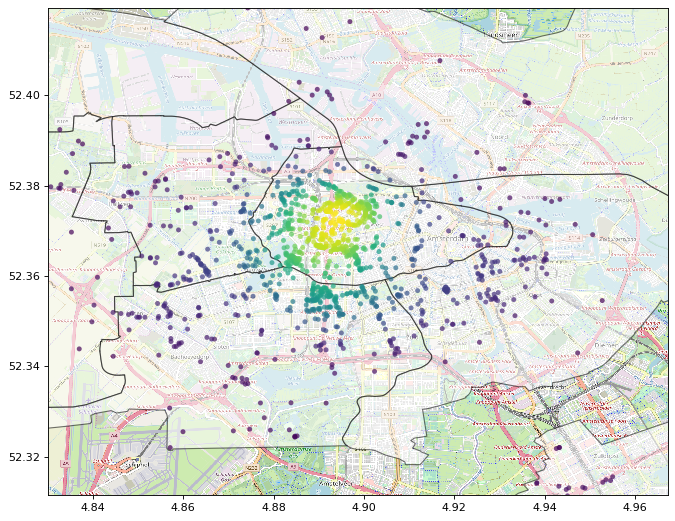

In [45]:

plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.plot()
ax1 = plt.axes()
ax1.set_xlim(bounding_box[0]+0.05, bounding_box[1]-0.05)
ax1.set_ylim(bounding_box[2]+0.025, bounding_box[3])
city.plot(ax=ax1, alpha=0.55, edgecolor="black", facecolor="white")
ax1.scatter(points["geometry"].x, points["geometry"].y, c=z, s=20, zorder=2, edgecolor='',  alpha=0.7)
ax1.imshow(osm_map, zorder=0, extent = bounding_box)
ax1.figure.savefig('./data/plot4.png')

In [30]:
xy = np.vstack([points["geometry"].x,points["geometry"].y])
z = gaussian_kde(xy)(xy)